# TPS 12/21 - Comparison of Classifiers

In this notebook, we test out four different models with mostly default settings:

* Self-Normalizing Neural Network
* XGBoost Classifier
* LightGBM Classifier
* CatBoost Classifier

**Note:** These are just quick baselines and not indicative of which model is ideal. In future experimentation we will use more training data, engineer features and tune hyperparameters.

In [1]:
# Global variables for testing changes to this notebook quickly
RANDOM_SEED = 0
NUM_FOLDS = 10
TRAIN_SIZE = 500000

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import time
import os
import pyarrow
import gc

# Hide warnings
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# Tensorflow/Keras
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras

# Model evaluation
from sklearn.base import clone
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Neural Network
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Gradient Boosting
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Tensorflow/Keras
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras


# Keras imports
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier


# Plotting
import matplotlib
import seaborn as sns
from matplotlib import pyplot as plt



# Load and Prepare Data

We have a total of 4 million observations in the original training data. For the sake of these benchmarks, we holdout 3 million rows as our test set and use the remaining 1 million for cross-validation.

In [3]:
# Save data as .feather format
train = pd.read_feather('../data/train.feather')

# Drop low/no variance 
train.drop(["Soil_Type7", "Id", "Soil_Type15"], axis=1, inplace=True)
train = train[train.Cover_Type != 5]

# Label Encoding
new_encoder = LabelEncoder()
train["Cover_Type"] = new_encoder.fit_transform(train["Cover_Type"])

# Split synthetic data
train, test = train_test_split(
    train, 
    train_size = TRAIN_SIZE, 
    random_state = RANDOM_SEED,
    stratify = train['Cover_Type'],
)


# features, data structure for summary scores
features = [x for x in train.columns if x not in ['Id','Cover_Type']]
new_rows = list()
gc.collect()

print(f'Training Size: {train.shape[0]} rows, {train.shape[1]} cols')
print(f'Holdout Size: {test.shape[0]} rows, {test.shape[1]} cols\n')

Training Size: 500000 rows, 53 cols
Holdout Size: 3499999 rows, 53 cols



# Scoring Function

In [4]:
# Scoring/Training Baseline Function
def score_holdout(sklearn_model, plot = True):
    
    # Store the holdout predictions
    oof_preds = np.zeros((train.shape[0],))
    test_preds = np.zeros((test.shape[0], len(train.Cover_Type.value_counts())))
    scores = np.zeros(NUM_FOLDS)
    times = np.zeros(NUM_FOLDS)
    print('')
    
    # Stratified k-fold cross-validation
    skf = StratifiedKFold(n_splits = NUM_FOLDS, shuffle = True, random_state = RANDOM_SEED)
    for fold, (train_idx, valid_idx) in enumerate(skf.split(train, train['Cover_Type'])):
        
        # Training and Validation Sets
        X_train = train[features].iloc[train_idx]
        X_valid = train[features].iloc[valid_idx]
        X_test = test[features]
        
        # Training and Target Labels
        y_train = train['Cover_Type'].iloc[train_idx]
        y_valid = train['Cover_Type'].iloc[valid_idx]
        y_test = test['Cover_Type']
        
        gc.collect()
        
        # Create model
        model = clone(sklearn_model)
            
        start = time.time()

        model.fit(X_train, y_train)
        
        end = time.time()
        
        # validation and test predictions
        valid_preds = np.ravel(model.predict(X_valid))
        test_preds += model.predict_proba(X_test)
        oof_preds[valid_idx] = valid_preds
        
        # fold auc score
        fold_acc = accuracy_score(y_valid, valid_preds)
        end = time.time()
        print(f'Fold {fold} Accuracy: {round(fold_acc, 5)} in {round(end-start,2)}s.')
        scores[fold] = fold_acc
        times[fold] = end-start
        
        time.sleep(0.5)
        
    test_preds = np.argmax(test_preds, axis = 1)
    holdout = accuracy_score(y_test, test_preds)
    #print('\n'+model.__class__.__name__)
    print("\nAverage CV Accuracy:", round(scores.mean(), 5))
    print("Worst CV Accuracy:", round(scores.min(), 5))
    print('Holdout Accuracy:', holdout)
    print(f'Training Time: {round(times.sum(), 2)}s')
    
    if plot:
        fig, ax = plt.subplots(figsize = (8,6))
        cm = confusion_matrix(y_test, test_preds, normalize = 'true')
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(ax = ax)
        plt.title("Confusion Matrix (% of Actual Labels)", fontsize=16)
        plt.xlabel("Predicted Labels", fontsize=14)
        plt.ylabel("Actual Labels", fontsize=14)
        plt.show()
    
    return scores.mean(), oof_preds, holdout


# Self-Normalizing Neural Network

In [5]:
# Keras Parameters
BATCH_SIZE = 512
EPOCHS = 100
EARLY_STOP = 5
VERBOSE = 0
NUM_CLASSES = len(train.Cover_Type.value_counts())

In [6]:
def build_model():
    model = keras.Sequential(
        [
            layers.InputLayer(input_shape = (len(features),)),
            layers.Dense(len(features), kernel_initializer="lecun_normal", activation="selu"),
            layers.Dense(3*len(features)//4, kernel_initializer="lecun_normal", activation="selu"),
            layers.Dense(len(features)//2, kernel_initializer="lecun_normal", activation="selu"),
            layers.Dense(NUM_CLASSES, activation="softmax"),
        ]
    )

    model.compile(
        loss = tf.keras.losses.SparseCategoricalCrossentropy(), 
        optimizer = tf.keras.optimizers.Adam(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    )
    return model 

In [7]:
# Fit parameters for Keras model
keras_pipeline = make_pipeline(
    RobustScaler(),
    KerasClassifier(
        build_model,
        batch_size = BATCH_SIZE,
        epochs = EPOCHS,
        verbose = VERBOSE,
        shuffle = True,
        validation_split = 0.1,
        callbacks = [
            EarlyStopping(
                patience=EARLY_STOP,
                monitor='val_loss',
                restore_best_weights=True,
            ),
        ],
    )
)


Fold 0 Accuracy: 0.95698 in 33.45s.
Fold 1 Accuracy: 0.9581 in 41.64s.
Fold 2 Accuracy: 0.9552 in 54.67s.
Fold 3 Accuracy: 0.95574 in 31.37s.
Fold 4 Accuracy: 0.95362 in 28.19s.
Fold 5 Accuracy: 0.95864 in 51.04s.
Fold 6 Accuracy: 0.9554 in 39.31s.
Fold 7 Accuracy: 0.95754 in 39.25s.
Fold 8 Accuracy: 0.95792 in 40.77s.
Fold 9 Accuracy: 0.95576 in 50.89s.

Average CV Accuracy: 0.95649
Worst CV Accuracy: 0.95362
Holdout Accuracy: 0.9587188453482415
Training Time: 410.58s


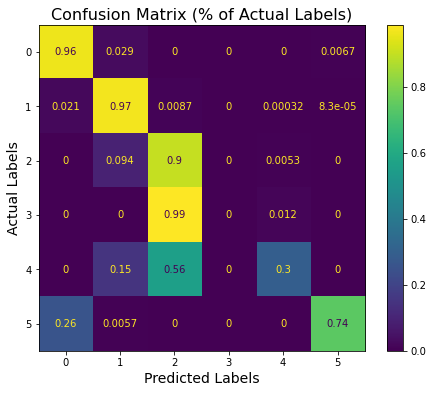

In [8]:
cv_score, oof_preds, holdout = score_holdout(keras_pipeline)

new_rows.append((
    'NN SELU', cv_score, holdout,
     *recall_score(train['Cover_Type'], oof_preds, average = None)
))

# XGBoost

In [9]:
# XGBoost Classifier
xgb_pipeline = make_pipeline(
    XGBClassifier(
        booster = 'gbtree',
        tree_method = 'hist',
        eval_metric = 'mlogloss',
        random_state = RANDOM_SEED,
    ),
)


Fold 0 Accuracy: 0.95862 in 19.56s.
Fold 1 Accuracy: 0.95792 in 19.9s.
Fold 2 Accuracy: 0.95696 in 18.84s.
Fold 3 Accuracy: 0.95772 in 19.21s.
Fold 4 Accuracy: 0.95616 in 19.37s.
Fold 5 Accuracy: 0.9593 in 19.2s.
Fold 6 Accuracy: 0.95668 in 19.16s.
Fold 7 Accuracy: 0.95776 in 18.97s.
Fold 8 Accuracy: 0.95814 in 19.27s.
Fold 9 Accuracy: 0.95734 in 19.82s.

Average CV Accuracy: 0.95766
Worst CV Accuracy: 0.95616
Holdout Accuracy: 0.9583254166644047
Training Time: 193.28s


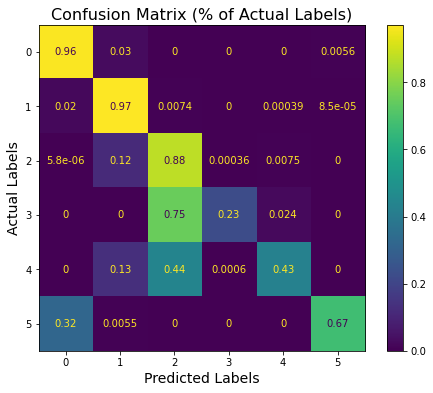

In [10]:
cv_score, oof_preds, holdout = score_holdout(xgb_pipeline)

new_rows.append((
    'XGBoost', cv_score, holdout,
     *recall_score(train['Cover_Type'], oof_preds, average = None)
))

# LightGBM

In [11]:
# LightGBM Classifier
lgbm_pipeline = make_pipeline(
    LGBMClassifier(
        #unbalanced_sets = True,
        metric = 'multi_logloss',
        random_state = RANDOM_SEED,
    ),
)


Fold 0 Accuracy: 0.94632 in 22.37s.
Fold 1 Accuracy: 0.9483 in 22.12s.
Fold 2 Accuracy: 0.94638 in 22.81s.
Fold 3 Accuracy: 0.95092 in 23.08s.
Fold 4 Accuracy: 0.93196 in 21.81s.
Fold 5 Accuracy: 0.9483 in 21.59s.
Fold 6 Accuracy: 0.94582 in 23.93s.
Fold 7 Accuracy: 0.9482 in 24.88s.
Fold 8 Accuracy: 0.9478 in 25.7s.
Fold 9 Accuracy: 0.93978 in 24.75s.

Average CV Accuracy: 0.94538
Worst CV Accuracy: 0.93196
Holdout Accuracy: 0.95520713005918
Training Time: 233.04s


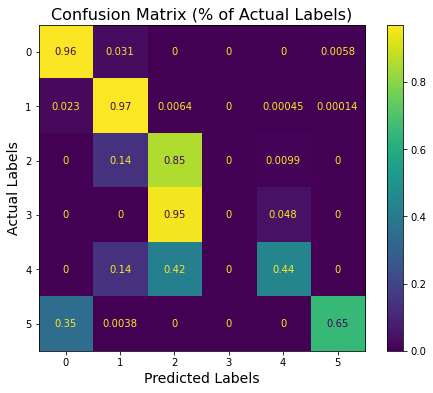

In [12]:
cv_score, oof_preds, holdout = score_holdout(lgbm_pipeline)

new_rows.append((
    'LightGBM', cv_score, holdout,
     *recall_score(train['Cover_Type'], oof_preds, average = None)
))

# CatBoost

In [13]:
# LightGBM Classifier
catboost_pipeline = make_pipeline(
    CatBoostClassifier(
        eval_metric = 'MultiClass',
        boosting_type = 'Plain',
        verbose = False,
        random_state = RANDOM_SEED,
    ),
)


Fold 0 Accuracy: 0.95832 in 191.47s.
Fold 1 Accuracy: 0.9595 in 193.45s.
Fold 2 Accuracy: 0.95632 in 188.97s.
Fold 3 Accuracy: 0.95848 in 183.85s.
Fold 4 Accuracy: 0.95648 in 193.19s.
Fold 5 Accuracy: 0.95926 in 188.22s.
Fold 6 Accuracy: 0.95704 in 194.38s.
Fold 7 Accuracy: 0.95814 in 185.72s.
Fold 8 Accuracy: 0.95884 in 200.31s.
Fold 9 Accuracy: 0.95724 in 199.76s.

Average CV Accuracy: 0.95796
Worst CV Accuracy: 0.95632
Holdout Accuracy: 0.9583542738155068
Training Time: 1919.32s


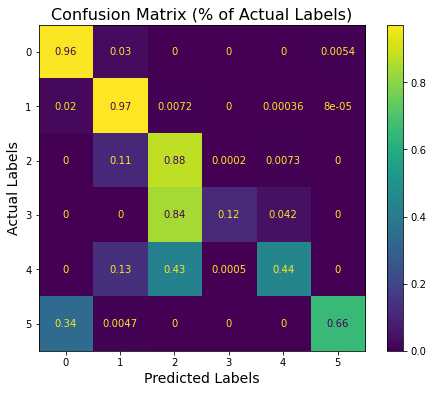

In [14]:
cv_score, oof_preds, holdout = score_holdout(catboost_pipeline)

new_rows.append((
    'CatBoost', cv_score, holdout,
     *recall_score(train['Cover_Type'], oof_preds, average = None)
))

# Summary

In [15]:
pd.DataFrame.from_records(
    data = new_rows,
    columns = ['model','cv_scores','holdout','recall_1','recall_2','recall_3','recall_4','recall_6','recall_7']
).sort_values('holdout')

,model,cv_scores,holdout,recall_1,recall_2,recall_3,recall_4,recall_6,recall_7
2,LightGBM,0.945378,0.955207,0.954566,0.961119,0.830281,0.000000,0.408964,0.622768
1,XGBoost,0.957660,0.958325,0.963682,0.971842,0.875000,0.170213,0.422969,0.663112
3,CatBoost,0.957962,0.958354,0.964499,0.972132,0.876758,0.106383,0.420168,0.648079
0,NN SELU,0.956490,0.958719,0.961404,0.968564,0.892618,0.000000,0.303922,0.728254
